In [ ]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.cluster import KMeans
import transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from torch import cuda
from sklearn.utils import class_weight
import seaborn as sns
from sklearn.decomposition import PCA

In [5]:
# Defining some key variables that will be used later
MAX_LEN = 512
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
INFERENCE_BATCH_SIZE = 8
EPOCHS = 2
LEARNING_RATE = 3e-5
MODEL_NAME = "bert-base-uncased"
NUM_CLUSTERS = 6

In [6]:
# Preparing and returning data in a format that can be directly used for training the model
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text_description = dataframe.TextDescription
        self.targets = dataframe.EncodedSeverity
        self.max_len = max_len

    def __len__(self):
        return len(self.text_description)

    def __getitem__(self, index):
        text_description = str(self.text_description[index])
        text_description = " ".join(text_description.split())

        inputs = self.tokenizer.encode_plus(
            text_description,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_token_type_ids=True
        )
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.long)
        }

In [7]:
# Creating the customized model, by adding a drop out and a linear layer on top of BERT to get the final output for the model. 
class BERTClass(torch.nn.Module):

    def __init__(self):
        super(BERTClass, self).__init__()
        self.pretrainedLayer = transformers.BertModel.from_pretrained(MODEL_NAME)
        self.dropOutLayer = torch.nn.Dropout(0.3)
        self.linearLayer = torch.nn.Linear(768, 6)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        _, output_1= self.pretrainedLayer(input_ids, attention_mask = attention_mask, token_type_ids = token_type_ids, return_dict=False)
        output_2 = self.dropOutLayer(output_1)
        output = self.linearLayer(output_2)

        return output

In [8]:
# Setting up the device for GPU usage
device = 'cuda' if cuda.is_available() else 'cpu'

In [9]:
# Initializes the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BERTClass()
model.to(device)

BERTClass(
  (pretrainedLayer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [10]:
# Reading, preparing, and splitting the dataset into a testing and training set
df = pd.read_csv('../DataSet/CleanDataSet.csv')

train_size = 0.7
train_dataset=df.sample(frac=train_size,random_state=200)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)


In [11]:
# Setting up the DataLoader objects for training and testing datasets, specifying how the data should be loaded during training
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [12]:
# Adapting weights to balance an unbalanced dataset 
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=
                                                 np.unique(df.EncodedSeverity),
                                                 y=df.EncodedSeverity)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss(class_weights)(outputs, targets)

In [13]:
# Using Adam Optimizer to optimize the loss
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [14]:
# Method for training the model
def train(epoch):
    model.train()
    fin_outputs = []
    for _,data in enumerate(training_loader, 0):
        input_ids = data['input_ids'].to(device, dtype = torch.long)
        attention_mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)
        outputs = model(input_ids, attention_mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        loss.backward()
        optimizer.step()

        fin_outputs.extend(outputs.cpu().detach().numpy().tolist())
    return fin_outputs

In [15]:
# Train the model
for epoch in range(EPOCHS):
    train(epoch)

Epoch: 0, Loss:  1.521986484527588
Epoch: 1, Loss:  2.2505576610565186


In [16]:
# Method for validating the training
def validation(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            input_ids = data['input_ids'].to(device, dtype = torch.long)
            attention_mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(input_ids, attention_mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.argmax(outputs, dim=1).cpu().detach().numpy().tolist())

    print("Sample Predictions:", fin_outputs[:20])  # Print first 20 predictions
    print("Actual Labels:", fin_targets[:20]) 

    return fin_outputs, fin_targets

In [17]:
# Validate the training
for epoch in range(EPOCHS):
    outputs, targets = validation(epoch)
    outputs = np.array(outputs)
    accuracy = metrics.accuracy_score(targets, outputs)
    b_accuracy = metrics.balanced_accuracy_score(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
    print(f"Accuracy Score = {accuracy}")
    print(f"Balanced Accuracy Score = {b_accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")

Sample Predictions: [3, 3, 4, 2, 4, 4, 1, 1, 4, 3, 2, 4, 3, 3, 4, 4, 4, 3, 1, 4]
Actual Labels: [2, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Accuracy Score = 0.5880952380952381
Balanced Accuracy Score = 0.2766967137819514
F1 Score (Micro) = 0.5880952380952381
F1 Score (Macro) = 0.21068188350350311
Sample Predictions: [3, 3, 4, 4, 1, 3, 3, 3, 4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 3]
Actual Labels: [4, 3, 4, 4, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
Accuracy Score = 0.5880952380952381
Balanced Accuracy Score = 0.2766967137819514
F1 Score (Micro) = 0.5880952380952381
F1 Score (Macro) = 0.21068188350350311


In [18]:
# Save the finetuned model
torch.save(model.state_dict(), "../Model/fine_tuned_bert.pth")

In [19]:
# Initialize the pretrained model
inference_model = BERTClass()
inference_model.to(device)

# Load the saved model weights
inference_model.load_state_dict(torch.load("../Model/best_fine_tuned_bert.pth", map_location=device))

<All keys matched successfully>

In [20]:
# Method for getting embeddings and their respective truth label
def get_fine_tuned_embeddings(data_loader):
    inference_model.eval()
    all_truth_labels = []
    embeddings_list = []

    with torch.no_grad():
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            
            # Extracting truth labels and converting to a 1d list
            labels = data['targets'].cpu().numpy()
            for label in labels:
                all_truth_labels.append(int(label))

            # Get embeddings from the fine-tuned model
            outputs = inference_model.pretrainedLayer(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, return_dict=True)
            embeddings = outputs['pooler_output'] 
            embeddings_list.append(embeddings.cpu().numpy())
    
    # Concatenate all embeddings into a single numpy array
    all_embeddings = np.vstack(embeddings_list)
    return all_embeddings, all_truth_labels

In [21]:
# Prepare inference dataloader
inference_dataset = CustomDataset(dataframe=df, tokenizer=tokenizer, max_len=MAX_LEN)
inference_params = {
    'batch_size': INFERENCE_BATCH_SIZE, 
    'shuffle': False,
    'num_workers': 0 
}
inference_loader=DataLoader(inference_dataset, **inference_params)

In [ ]:
# Getting embeddings and their truth labels
embeddings_test, all_truth_labels = get_fine_tuned_embeddings(inference_loader)

In [ ]:
# Executing Kmeans and deleting the outlier that is by itself in a cluster
embeddings = embeddings_test
original_indices = np.arange(len(embeddings))

kmeans = KMeans(
        n_clusters=NUM_CLUSTERS,
        max_iter=100,
        init='k-means++',
        n_init="auto",
        random_state=50,
    ).fit(embeddings)
cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)

# Find the cluster with only one data point
print(f"Number of elements assigned to each cluster: {cluster_sizes}")
for cluster_id, size in zip(cluster_ids, cluster_sizes):
    if size == 1:
        outlier_cluster = cluster_id
        break

outlier = np.where(kmeans.labels_ == outlier_cluster)[0]
embeddings = np.delete(embeddings, outlier, axis=0)

# Map back to original indices
original_outlier_ids = original_indices[outlier]
print(f"Original ID of outlier: {original_outlier_ids}")

# Remove the point from the original data
cleaned_data = np.delete(embeddings, original_outlier_ids, axis=0)
print(f"Cleaned data shape: {cleaned_data.shape}")

cleaned_labels = np.delete(all_truth_labels, original_outlier_ids, axis=0)

Number of elements assigned to each cluster: [4397    1  365 5085 1607 3946]
Original ID of outlier: [7042]
Cleaned data shape: (15399, 768)


In [54]:
# Executing and evaluating Kmeans
cluster_labels = KMeans(
        n_clusters=NUM_CLUSTERS,
        max_iter=100,
        init='k-means++',
        n_init="auto",
        random_state=50,
    ).fit_predict(embeddings)
cluster_ids, cluster_sizes = np.unique(cluster_labels, return_counts=True)

print(f"Number of elements assigned to each cluster: {cluster_sizes}")

nmi = metrics.normalized_mutual_info_score(cleaned_labels, cluster_labels, average_method='arithmetic')
print("NMI: ", nmi)
ari = metrics.adjusted_rand_score(cleaned_labels, cluster_labels)
print("ARI: ", ari)

Number of elements assigned to each cluster: [4164 1608 3272 3674 2302  380]
NMI:  0.007269535692850055
ARI:  0.006102971014023783


<Axes: xlabel='PCA1', ylabel='PCA2'>

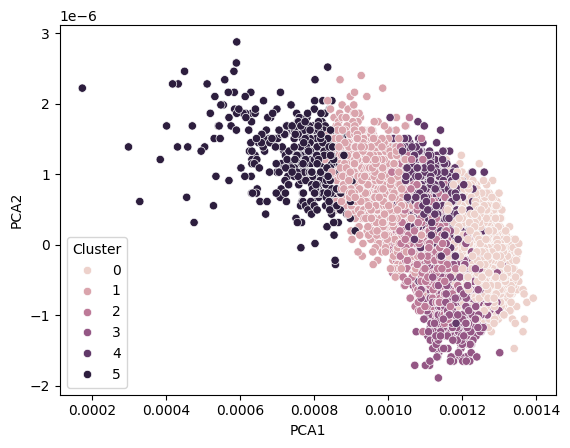

In [55]:
# Visualizing the clusters
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

df_visual = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
df_visual['Cluster'] = cluster_labels

sns.scatterplot(x="PCA1", y="PCA2", data=df_visual, hue="Cluster")